# Project

## Part 1: MNIST Classifier

### Prepare the packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,Normalize,Compose
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import os
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Some tips:

1. Import `torch` in order to use Pytorch to build and train my model.
2. Import `torch.nn` to build the network structure.
3. Import `torch.optim` and `StepLR` to optimize the model, the former one is for the model, the latter one is for the learning-rate
4. Import `torch.nn.functional` to get the related functions, such as `ReLU`.
5. Import `Dataset`,`DataLoader`,`datasets` to get the datasets which are used to train the model.
6. Import `ToTensor`,`Normalize`,`Compose` in order to preprocess the data.
7. Import `summary` to show the network structure.
8. Import `numpy` and `matplotlib.pyplot` for the data visualization.
9. Import `os` to make me happy. :-)
10. `%config InlineBackend.figure_format = 'svg'`：To make the output format of pictures `svg`.
11. `%matplotlib inline`: To make pictures always shown.

### Prepare the data

In [2]:
learning_rate=0.005
epochs=3
rootdir=os.getcwd()

train_data=DataLoader(datasets.MNIST(
    root=rootdir,
    train=True,
    download=True,
    transform=Compose([ToTensor(),Normalize((0.1307,),(0.3081,))])
),batch_size=60,shuffle=True)

test_data=DataLoader(datasets.MNIST(
    root=rootdir,
    train=False,
    download=True,
    transform=Compose([ToTensor(),Normalize((0.1307,),(0.3081,))])
),batch_size=1,shuffle=True)

Some tips:

1. `learning-rate`: No need to explain.
2. `epochs`: The training and testing times.
3. `rootdir`: The path which storages the datasets and model.
4. `ToTensor()`: To transform the image into tensor.
5. `Normalize()`: To normalize the data to make training and testing faster. 
    >`Normalize(mean,std)` $x_{\text{out}}=\dfrac{x_{\text{in}}-\text{mean}}{\text{std}}$
6. `batch_size`: Batch processing can make training and testing faster.
7. `shuffle`: To ensure the dataset is random, and improve the credibility of model accuracy.
8. `record`: Just record the loss and accuracy for the data visualization.

### Define the network structure

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.network=nn.Sequential(
            nn.Conv2d(1,16,kernel_size=2,stride=1,padding=1),
            # I [1   28  28  ]
            # O [16  29  29  ]
            nn.ReLU(inplace=True),
            # I [16  29  29  ]
            # O [16  29  29  ]
            nn.MaxPool2d(kernel_size=2,stride=1),
            # I [16  29  29  ]
            # O [16  28  28  ]
            nn.Conv2d(16,32,kernel_size=2,padding=1),
            # I [16  28  28  ]
            # O [32  29  29  ]
            nn.ReLU(inplace=True),
            # I [32  29  29  ]
            # O [32  29  29  ]
            nn.MaxPool2d(kernel_size=2,stride=2),
            # I [32  29  29  ]
            # O [32  14  14  ]
            nn.Conv2d(32,48,kernel_size=2),
            # I [32  14  14  ]
            # O [48  13  13  ]
            nn.ReLU(inplace=True),
            # I [48  13  13  ]
            # O [48  13  13  ]
            nn.MaxPool2d(kernel_size=2,stride=2),
            # I [48  13  13  ]
            # O [48  6   6   ]
            nn.Flatten(1),
            nn.Dropout(0.25),
            nn.Linear(1728,324),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(324,128),
            nn.ReLU(inplace=True),
            nn.Linear(128,10),
        )
    def forward(self,x):
        result=F.log_softmax(self.network(x),dim=1)
        return result

Some tips:
1. `nn.Sequential`: To package the layers linearly.
2. `inplace`: To adapt to the larger models and make the training and testing faster.
3. `nn.Dropout(p=0.5)`: Randomly zeroes some of the elements of the input tensor with probability $p$, to make model more stable.
4. `F.log_softmax()`: Compress the data to $[0,1]$ to represent the probability.
    >`log_softmax()` can handle the overflow and underflow, but `softmax()` cannot.

### Prepare the model and other method

In [4]:
model=CNN()
criterion=F.nll_loss
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
scheduler=StepLR(optimizer,step_size=1,gamma=0.8)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 29, 29]              80
              ReLU-2           [-1, 16, 29, 29]               0
         MaxPool2d-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 29, 29]           2,080
              ReLU-5           [-1, 32, 29, 29]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 48, 13, 13]           6,192
              ReLU-8           [-1, 48, 13, 13]               0
         MaxPool2d-9             [-1, 48, 6, 6]               0
          Flatten-10                 [-1, 1728]               0
          Dropout-11                 [-1, 1728]               0
           Linear-12                  [-1, 324]         560,196
             ReLU-13                  [-1, 324]               0
          Dropout-14                  [

f:\exe\python\venv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Some tips:
1. `nll_loss`: A loss function often used in classification task.
2. `Adam`: An optimizer but I have no deep understanding.
3. `StepLr`: An learning-rate optimizer.
4. `summary(model)`: A method can easily print the network structure imported from package `torchsummary`.

### Define the training and testing method

In [5]:
def train(model,train_data,optimizer,epoch):
    model.train()
    correct=0
    for batch,(data,target) in enumerate(train_data):
        optimizer.zero_grad()
        result=model(data)
        train_loss=criterion(result,target)
        train_loss.backward()
        pred=result.argmax(dim=1,keepdim=True)
        accuracy=pred.eq(target.view_as(pred)).sum().item()
        correct+=accuracy
        loss_record.append(train_loss.item())
        accuracy_record.append(accuracy/len(data))
        optimizer.step()
        if batch%10==0 :
            print("Train Epoch{}:[{}/{}({:.0f}%)]\tLoss:{:.6f}\tAccuracy:{}/{}({:.2f}%)".format(
                epoch+1,batch*len(data),len(train_data.dataset),
                100.*batch*len(data)/len(train_data.dataset),train_loss.item(),
                correct,10*len(data),100.*correct/(10*len(data))))
            correct=0
def test(model,test_data):
    model.eval()
    loss=0
    correct=0
    with torch.no_grad():
        for batch,(data,target) in enumerate(test_data):
            result=model(data)
            test_loss=criterion(result,target)
            pred=result.argmax(dim=1,keepdim=True)
            accuracy=pred.eq(target.view_as(pred)).sum().item()
            correct+=accuracy
            loss+=test_loss.item()
        loss/=len(test_data.dataset)
    print("Test Set: Average Loss:{:.6f} Accuracy:{}/{}({:.2f}%)".format(
        loss,correct,
        len(test_data.dataset),
        100.*correct/len(test_data.dataset)))

Some tips:
1. `optimizer.zero_grad()`: To make the optimizer not save the data last time.
2. `train_loss.backward()`: To do back propagation.
3. `accuracy=pred.eq(target.view_as(pred)).sum().item()`: To calculate the accuracy.
4. `optimizer.step()`: To update the parameters based on the result of back propagation.
5. `with torch.no_grad():`: To forbid the model to calculate the gradient and make testing faster.

### Train and test the model

In [6]:
loss_record=list()
accuracy_record=list()
for epoch in range(epochs):
    train(model,train_data,optimizer,epoch)
    test(model,test_data)
    scheduler.step()

Train Epoch1:[0/60000(0%)]	Loss:2.286677	Accuracy:8/600(1.33%)
Train Epoch1:[600/60000(1%)]	Loss:1.437202	Accuracy:166/600(27.67%)
Train Epoch1:[1200/60000(2%)]	Loss:1.010720	Accuracy:394/600(65.67%)
Train Epoch1:[1800/60000(3%)]	Loss:0.510364	Accuracy:474/600(79.00%)
Train Epoch1:[2400/60000(4%)]	Loss:0.456168	Accuracy:508/600(84.67%)
Train Epoch1:[3000/60000(5%)]	Loss:0.635851	Accuracy:522/600(87.00%)
Train Epoch1:[3600/60000(6%)]	Loss:0.170877	Accuracy:533/600(88.83%)
Train Epoch1:[4200/60000(7%)]	Loss:0.326703	Accuracy:558/600(93.00%)
Train Epoch1:[4800/60000(8%)]	Loss:0.253464	Accuracy:545/600(90.83%)
Train Epoch1:[5400/60000(9%)]	Loss:0.325256	Accuracy:550/600(91.67%)
Train Epoch1:[6000/60000(10%)]	Loss:0.151439	Accuracy:556/600(92.67%)
Train Epoch1:[6600/60000(11%)]	Loss:0.112597	Accuracy:560/600(93.33%)
Train Epoch1:[7200/60000(12%)]	Loss:0.135273	Accuracy:562/600(93.67%)
Train Epoch1:[7800/60000(13%)]	Loss:0.289546	Accuracy:558/600(93.00%)
Train Epoch1:[8400/60000(14%)]	Loss:0

Train Epoch2:[9600/60000(16%)]	Loss:0.119368	Accuracy:584/600(97.33%)
Train Epoch2:[10200/60000(17%)]	Loss:0.032060	Accuracy:583/600(97.17%)
Train Epoch2:[10800/60000(18%)]	Loss:0.159791	Accuracy:587/600(97.83%)
Train Epoch2:[11400/60000(19%)]	Loss:0.155711	Accuracy:581/600(96.83%)
Train Epoch2:[12000/60000(20%)]	Loss:0.046135	Accuracy:590/600(98.33%)
Train Epoch2:[12600/60000(21%)]	Loss:0.069423	Accuracy:583/600(97.17%)
Train Epoch2:[13200/60000(22%)]	Loss:0.086981	Accuracy:586/600(97.67%)
Train Epoch2:[13800/60000(23%)]	Loss:0.062800	Accuracy:587/600(97.83%)
Train Epoch2:[14400/60000(24%)]	Loss:0.086190	Accuracy:589/600(98.17%)
Train Epoch2:[15000/60000(25%)]	Loss:0.146493	Accuracy:586/600(97.67%)
Train Epoch2:[15600/60000(26%)]	Loss:0.002042	Accuracy:587/600(97.83%)
Train Epoch2:[16200/60000(27%)]	Loss:0.051544	Accuracy:589/600(98.17%)
Train Epoch2:[16800/60000(28%)]	Loss:0.076524	Accuracy:587/600(97.83%)
Train Epoch2:[17400/60000(29%)]	Loss:0.069723	Accuracy:581/600(96.83%)
Train E

Train Epoch3:[19200/60000(32%)]	Loss:0.131054	Accuracy:596/600(99.33%)
Train Epoch3:[19800/60000(33%)]	Loss:0.245793	Accuracy:590/600(98.33%)
Train Epoch3:[20400/60000(34%)]	Loss:0.052850	Accuracy:591/600(98.50%)
Train Epoch3:[21000/60000(35%)]	Loss:0.057597	Accuracy:585/600(97.50%)
Train Epoch3:[21600/60000(36%)]	Loss:0.100235	Accuracy:584/600(97.33%)
Train Epoch3:[22200/60000(37%)]	Loss:0.018452	Accuracy:594/600(99.00%)
Train Epoch3:[22800/60000(38%)]	Loss:0.098165	Accuracy:589/600(98.17%)
Train Epoch3:[23400/60000(39%)]	Loss:0.034232	Accuracy:589/600(98.17%)
Train Epoch3:[24000/60000(40%)]	Loss:0.139048	Accuracy:590/600(98.33%)
Train Epoch3:[24600/60000(41%)]	Loss:0.036723	Accuracy:586/600(97.67%)
Train Epoch3:[25200/60000(42%)]	Loss:0.022681	Accuracy:593/600(98.83%)
Train Epoch3:[25800/60000(43%)]	Loss:0.104245	Accuracy:589/600(98.17%)
Train Epoch3:[26400/60000(44%)]	Loss:0.125932	Accuracy:587/600(97.83%)
Train Epoch3:[27000/60000(45%)]	Loss:0.163775	Accuracy:586/600(97.67%)
Train 

Some tips:
1. `scheduler.step()`: To update the learning-rate in order not to overfit and underfit.

### Show the accuracy and loss curve

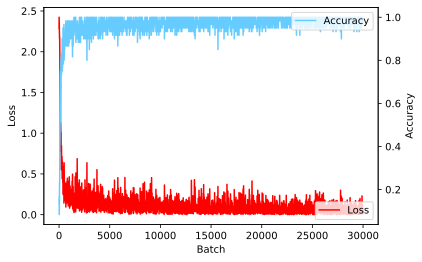

In [7]:
x_draw=10*np.arange(len(loss_record))
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.plot(x_draw, loss_record, label = "Loss", color = "#ff0000")
ax1.legend(loc = 4)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Batch")
ax = plt.gca()
ax2 = plt.twinx()
ax2.set_ylabel("Accuracy")
ax2.plot(x_draw, accuracy_record, label = "Accuracy",color="#66ccff")
ax2.legend(loc = 1)
plt.show()

### Show and load the model

8


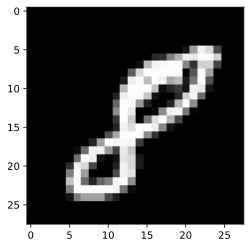

In [8]:
torch.save(model,rootdir+"/model.pth")

def predict(data_input):
    model=torch.load(rootdir+"/model.pth")
    with torch.no_grad():
        out=model(data_input)
        result=torch.max(out.data,1)
        return int(result.indices)

images, labels = next(iter(train_data))
plt.imshow(images[0].reshape(28,28),cmap='gray')
print(predict(images[0].reshape(1,1,28,28)))

Some tips:
1. `torch.save(path)`: To save the model to load and use.
2. `torch.load(path)`: To load the model to use.
3. `next(iter(Iterable Object))`: To get the first iterable object and point to the next.

## Part 2: Adversarial Attack

### Before everything

Adversarial Attack: For the original image $x$, a small perturbation $\eta$ is added to obtain the adversarial sample $x = x + \eta$, making the classifier misclassify when the adversarial sample is used as input.

There are two effective attacking method, one is called `FGSM (Fast Gradient Sign Method)`, one is called `PGD (Project Gradient Descent)` which is the same as `K-FGSM`.
1. `FGSM(epsilon, x)`: $x = x + \epsilon sign(\nabla_{x} J(\theta, x, y))$

    To add small perturbations to the image for the purpose of attack.
    
    $x$: The input.
    
    $\epsilon$: The size of the perturbation.
    
    $sign()$: The sign function, $sign(x)=\begin{cases}1, x>0 \\0, x=0\\-1, x<0 \end{cases}$
    
    $J(\theta, x, y)$: The loss function.
    
    $\theta$: The parameters of model.
    
    $y$: The true labels.

2. `PGD(k, epsilon, x)` or `K-FGSM(k, epsilon, x)`: $x^{t+1}=\prod_{x+S}(x^t+\epsilon sign(\nabla_x J(\theta,x,y)))$

    Better than `FGSM` in non-linear model.
    
    $k$: The number of iterations.
    
    Attention:
    1. Random initialization is required for the input image。
    2. Truncation with perturbation after each iteration step is performed to prevent $\parallel \eta \parallel_{\infty}>\epsilon$

### Prepare the data

In [9]:
k=3
epsilon=0.25

Some tips:

We present the concept of **Attack Intensity** here.

Once `k` and `epsilon` is determined, the attack intensity is determined. The larger `k` is, the 
greater attack intensity is. The larger `epsilon` is, the greater attack intensity is.

### Define the `FGSM` method and attacking method

In [10]:
def FGSM(data,epsilon,data_grad):
    sign_data_grad=data_grad.sign()
    attacked_data=data+epsilon*sign_data_grad
    attacked_data=torch.clamp(attacked_data,0,1)
    return attacked_data
def attack_test(model,test_data,k,epsilon):
    correct=0
    count=0
    for batch,(data,target) in enumerate(test_data):
        data.requires_grad=True
        for i in range(k):
            data.retain_grad()
            model.zero_grad()
            data_temp=data+torch.Tensor(np.random.uniform(-epsilon,epsilon,data.shape))
            result=model(data_temp)
            attack_test_loss=criterion(result,target)
            pred=result.argmax(dim=1,keepdim=True)
            accuracy=pred.eq(target.view_as(pred)).sum().item()
            attack_accuracy_record[i]+=accuracy
            if(i==k-1)and(count<5)and(accuracy==0):
                temp={
                    'data':data.detach().reshape(28,28),
                    'target':int(target),
                    'result':int(pred)
                }
                attack_image_record.append(temp)
                count+=1
            attack_test_loss.backward(retain_graph=True)
            data_grad=data.grad.data
            data=FGSM(data_temp,epsilon,data_grad)
            if((batch+1)%500==0) and (i==k-1):
                for j in range(k):
                    print("Attack{}:\tAccuracy:{}/{}({:.2f}%)".format(j,attack_accuracy_record[j],(batch+1),
                                                                      100.*attack_accuracy_record[j]/(batch+1)))
    for i in range(k):
        print("Attack Test Set:\tAttack Times{}\tAccuracy:{}/{}({}%)".format(i,attack_accuracy_record[i],
                                                                            len(test_data.dataset),
                                                                            100.*attack_accuracy_record[i]/
                                                                             len(test_data.dataset)))

Some tips:
1. `torch.clamp(image,min,max)`: To clamp each element of the input tensor to the interval $[min,max]$, and return the result to a new tensor.
2. `data.retain_grad()`: To save the gradient of non-leaf nodes.
3. `data.detach()`: To forbid the data to be calculated gradient and it can be transformed into `numpy.ndarray`.

### Attack the model and show some attacked images

Attack0:	Accuracy:487.0/500(97.40%)
Attack1:	Accuracy:467.0/500(93.40%)
Attack2:	Accuracy:126.0/500(25.20%)
Attack0:	Accuracy:981.0/1000(98.10%)
Attack1:	Accuracy:939.0/1000(93.90%)
Attack2:	Accuracy:263.0/1000(26.30%)
Attack0:	Accuracy:1478.0/1500(98.53%)
Attack1:	Accuracy:1418.0/1500(94.53%)
Attack2:	Accuracy:403.0/1500(26.87%)
Attack0:	Accuracy:1977.0/2000(98.85%)
Attack1:	Accuracy:1893.0/2000(94.65%)
Attack2:	Accuracy:530.0/2000(26.50%)
Attack0:	Accuracy:2473.0/2500(98.92%)
Attack1:	Accuracy:2363.0/2500(94.52%)
Attack2:	Accuracy:673.0/2500(26.92%)
Attack0:	Accuracy:2965.0/3000(98.83%)
Attack1:	Accuracy:2825.0/3000(94.17%)
Attack2:	Accuracy:801.0/3000(26.70%)
Attack0:	Accuracy:3458.0/3500(98.80%)
Attack1:	Accuracy:3284.0/3500(93.83%)
Attack2:	Accuracy:936.0/3500(26.74%)
Attack0:	Accuracy:3954.0/4000(98.85%)
Attack1:	Accuracy:3756.0/4000(93.90%)
Attack2:	Accuracy:1060.0/4000(26.50%)
Attack0:	Accuracy:4445.0/4500(98.78%)
Attack1:	Accuracy:4226.0/4500(93.91%)
Attack2:	Accuracy:1198.0/4

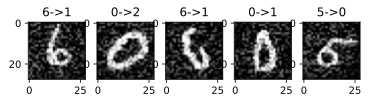

In [11]:
attack_accuracy_record=np.zeros(k)
attack_image_record=list()
attack_test(model,test_data,k,epsilon)
attack_ax=list()
for i in range(len(attack_image_record)):
    attack_ax.append(0)
    attack_ax[i]=plt.subplot(1,5,i+1)
    plt.title("{}->{}".format(attack_image_record[i]['target'],attack_image_record[i]['result']))
    plt.imshow(attack_image_record[i]['data'],cmap='gray')

## Part 3: Adversarial Defence

### Before everything

For defense against adversarial attacks, the most common approach is to train the neural network using adversarial samples.

So we should attack the training dataset and use it to train the model.

### Define the network structure

In [12]:
class Defence_CNN(CNN):
    def __init__(self):
        super(Defence_CNN,self).__init__()

Some tips:
1. Just the same as the network defined above. 

### Prepare the data

In [13]:
defence_train_k=3
defence_train_epsilon=0.25
defence_test_k=3
defence_test_epsilon=0.25
defence_learning_rate=0.005
defence_epochs=3
defence_model=Defence_CNN()
defence_criterion=F.nll_loss
defence_optimizer=optim.Adam(defence_model.parameters(),lr=defence_learning_rate)
defence_iter_optimizer=optim.Adam(defence_model.parameters(),lr=0.05*defence_learning_rate)
defence_scheduler=StepLR(defence_optimizer,step_size=1,gamma=0.8)
defence_iter_scheduler=StepLR(defence_iter_optimizer,step_size=1,gamma=0.8)

Some tips:
1. If information is symmetry, `defence_train_k` equals `defence_test_k`, and `defence_train_epsilon` equals `defence_test_epsilon`. And attacking seems useless.
2. If information is asymmetry, `defence_train_k` shouldn't equal `defence_test_k`, and `defence_train_epsilon` shouldn't `equal defence_test_epsilon`. So there is a concept called **Defence Threshold**, which will be discussed later.

### Define the training and testing method

In [14]:
def defence_train(model,train_data,k,epsilon,epoch):
    model.train()
    correct=0
    for batch,(data,target) in enumerate(train_data):
        data.requires_grad=True
        for i in range(k-1):
            data.retain_grad()
            defence_iter_optimizer.zero_grad()
            model.zero_grad()
            data_temp=data+torch.Tensor(np.random.uniform(-epsilon,epsilon,data.shape))
            result=model(data_temp)
            defence_train_loss=defence_criterion(result,target)
            defence_train_loss.backward(retain_graph=True)
            data_grad=data.grad.data
            data=FGSM(data_temp,epsilon,data_grad)
            defence_iter_optimizer.step()
        ##################################################################
        defence_optimizer.zero_grad()
        result=model(data)
        defence_train_loss=defence_criterion(result,target)
        defence_train_loss.backward(retain_graph=True)
        pred=result.argmax(dim=1,keepdim=True)
        accuracy=pred.eq(target.view_as(pred)).sum().item()
        correct+=accuracy
        defence_loss_record.append(defence_train_loss.item())
        defence_accuracy_record.append(accuracy/len(data))
        defence_optimizer.step()
        if(batch%10==0):
            print("Denfence Epoch{}:[{}/{}({:.0f}%)]\tLoss:{:.6f}\tAccuracy:{}/{}({:.2f}%)".format(
                epoch+1,batch*len(data),len(train_data.dataset),
                100.*batch*len(data)/len(train_data.dataset),defence_train_loss.item(),
                correct,10*len(data),100.*correct/(10*len(data))))
            correct=0
def defence_test(model,test_data,k,epsilon):
    model.eval()
    loss=0
    correct=0
    for batch,(data,target) in enumerate(test_data):
        data.requires_grad=True
        for i in range(k-1):
            data.retain_grad()
            data_temp=data+torch.Tensor(np.random.uniform(-epsilon,epsilon,data.shape))
            model.zero_grad()
            result=model(data_temp)
            defence_test_loss=defence_criterion(result,target)
            defence_test_loss.backward(retain_graph=True)
            data_grad=data.grad.data
            data=FGSM(data_temp,epsilon,data_grad)
        ##################################################################
        with torch.no_grad():
            result=model(data)
            defence_test_loss=defence_criterion(result,target)
            pred=result.argmax(dim=1,keepdim=True)
            accuracy=pred.eq(target.view_as(pred)).sum().item()
            if(len(defence_image_record)<5):
                temp={
                    'data':data.detach().reshape(28,28),
                    'target':int(target),
                    'result':int(pred)
                }
                defence_image_record.append(temp)
            correct+=accuracy
            loss+=defence_test_loss.item()
        loss/=len(test_data.dataset)
    print("Test Set: Average Loss:{:.6f} Accuracy:{}/{}({:.2f}%)".format(
        loss,correct,
        len(test_data.dataset),
        100.*correct/len(test_data.dataset)))

Some tips:
1. The codes above the diving line are getting the attacked image.

### Train and test the model

In [15]:
defence_loss_record=list()
defence_accuracy_record=list()
defence_image_record=list()
for epoch in range(defence_epochs):
    defence_train(defence_model,train_data,defence_train_k,defence_train_epsilon,epoch)
    defence_test(defence_model,test_data,defence_test_k,defence_test_epsilon)
    defence_iter_scheduler.step()
    defence_scheduler.step()

Denfence Epoch1:[0/60000(0%)]	Loss:2.301138	Accuracy:6/600(1.00%)
Denfence Epoch1:[600/60000(1%)]	Loss:2.297885	Accuracy:66/600(11.00%)
Denfence Epoch1:[1200/60000(2%)]	Loss:2.196219	Accuracy:102/600(17.00%)
Denfence Epoch1:[1800/60000(3%)]	Loss:1.925039	Accuracy:145/600(24.17%)
Denfence Epoch1:[2400/60000(4%)]	Loss:1.870440	Accuracy:204/600(34.00%)
Denfence Epoch1:[3000/60000(5%)]	Loss:1.523819	Accuracy:222/600(37.00%)
Denfence Epoch1:[3600/60000(6%)]	Loss:1.570380	Accuracy:281/600(46.83%)
Denfence Epoch1:[4200/60000(7%)]	Loss:1.199089	Accuracy:300/600(50.00%)
Denfence Epoch1:[4800/60000(8%)]	Loss:1.281954	Accuracy:304/600(50.67%)
Denfence Epoch1:[5400/60000(9%)]	Loss:1.148769	Accuracy:346/600(57.67%)
Denfence Epoch1:[6000/60000(10%)]	Loss:1.135611	Accuracy:349/600(58.17%)
Denfence Epoch1:[6600/60000(11%)]	Loss:1.178540	Accuracy:374/600(62.33%)
Denfence Epoch1:[7200/60000(12%)]	Loss:1.350441	Accuracy:378/600(63.00%)
Denfence Epoch1:[7800/60000(13%)]	Loss:0.722756	Accuracy:375/600(62.5

Denfence Epoch2:[6600/60000(11%)]	Loss:0.537836	Accuracy:516/600(86.00%)
Denfence Epoch2:[7200/60000(12%)]	Loss:0.591552	Accuracy:510/600(85.00%)
Denfence Epoch2:[7800/60000(13%)]	Loss:0.381190	Accuracy:521/600(86.83%)
Denfence Epoch2:[8400/60000(14%)]	Loss:0.471854	Accuracy:516/600(86.00%)
Denfence Epoch2:[9000/60000(15%)]	Loss:0.415438	Accuracy:517/600(86.17%)
Denfence Epoch2:[9600/60000(16%)]	Loss:0.270985	Accuracy:514/600(85.67%)
Denfence Epoch2:[10200/60000(17%)]	Loss:0.407209	Accuracy:521/600(86.83%)
Denfence Epoch2:[10800/60000(18%)]	Loss:0.393158	Accuracy:528/600(88.00%)
Denfence Epoch2:[11400/60000(19%)]	Loss:0.260192	Accuracy:534/600(89.00%)
Denfence Epoch2:[12000/60000(20%)]	Loss:0.300742	Accuracy:518/600(86.33%)
Denfence Epoch2:[12600/60000(21%)]	Loss:0.497798	Accuracy:523/600(87.17%)
Denfence Epoch2:[13200/60000(22%)]	Loss:0.198101	Accuracy:529/600(88.17%)
Denfence Epoch2:[13800/60000(23%)]	Loss:0.216751	Accuracy:540/600(90.00%)
Denfence Epoch2:[14400/60000(24%)]	Loss:0.25

Denfence Epoch3:[13200/60000(22%)]	Loss:0.412622	Accuracy:543/600(90.50%)
Denfence Epoch3:[13800/60000(23%)]	Loss:0.273563	Accuracy:557/600(92.83%)
Denfence Epoch3:[14400/60000(24%)]	Loss:0.266197	Accuracy:554/600(92.33%)
Denfence Epoch3:[15000/60000(25%)]	Loss:0.268051	Accuracy:543/600(90.50%)
Denfence Epoch3:[15600/60000(26%)]	Loss:0.317336	Accuracy:541/600(90.17%)
Denfence Epoch3:[16200/60000(27%)]	Loss:0.090048	Accuracy:563/600(93.83%)
Denfence Epoch3:[16800/60000(28%)]	Loss:0.117650	Accuracy:544/600(90.67%)
Denfence Epoch3:[17400/60000(29%)]	Loss:0.174940	Accuracy:561/600(93.50%)
Denfence Epoch3:[18000/60000(30%)]	Loss:0.200550	Accuracy:554/600(92.33%)
Denfence Epoch3:[18600/60000(31%)]	Loss:0.119345	Accuracy:555/600(92.50%)
Denfence Epoch3:[19200/60000(32%)]	Loss:0.294940	Accuracy:554/600(92.33%)
Denfence Epoch3:[19800/60000(33%)]	Loss:0.176231	Accuracy:544/600(90.67%)
Denfence Epoch3:[20400/60000(34%)]	Loss:0.254573	Accuracy:551/600(91.83%)
Denfence Epoch3:[21000/60000(35%)]	Los

Some tips:

If information is symmetry, the accuracy can be seen as standard accuracy. As shown above, When `defence_train_k` equals `defence_test_k` equals $3$, and `defence_train_epsilon` equals `defence_test_epsilon` equals $0.25$, the standard accuracy is $96.06\%$.

If information is asymmetry, We present the concept of **Defense Threshold** here.
To begin with, once `defence_train_k` and `defence_train_epsilon` is determined, the defence threshold of the model is determined, the attack intensity is determined. In general, an attack whose attack intensity is lower than the defence threshold of the model, the accuracy will be greater than the standard accuracy. Instead, an attack with greater attack intensity than the defence threshold, the accuracy will be lower, while the influence of `epsilon` is greater than the influence of `k`.

In our experiments， when `defence_test_k` equals $2$ and `defence_test_epsilon` equals $0.25$, the accuracy is nearly $97\%$. While when `defence_test_k` equals $3$ and `defence_test_epsilon` equals $0.1$, the accuracy is even about $98\%$. These are the examples with relatively high defence threshold.

While when `defence_test_k` equals $4$ and `defence_test_epsilon` equals $0.25$, the accuracy is nearly $30\%$. While when `defence_test_k` equals $3$ and `defence_test_epsilon` equals $0.4$, the accuracy is even about $16\%$. These are the examples with relatively low defence threshold.

But the experiments result hasn't been saved. :-(.

### Show the accuracy and loss curve

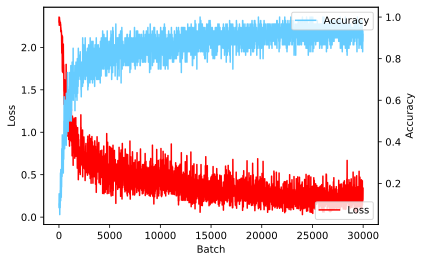

In [16]:
defence_x_draw=10*np.arange(len(defence_loss_record))
fig = plt.figure()
ax3 = fig.add_subplot()
ax3.plot(defence_x_draw, defence_loss_record, label = "Loss", color = "#ff0000")
ax3.legend(loc = 4)
ax3.set_ylabel("Loss")
ax3.set_xlabel("Batch")
defence_ax = plt.gca()
ax4 = plt.twinx()
ax4.set_ylabel("Accuracy")
ax4.plot(defence_x_draw, defence_accuracy_record, label = "Accuracy",color="#66ccff")
ax4.legend(loc = 1)
plt.show()

Some tips:
1. From the curve, we can conclude that the loss and accuracy curve is hard to converge.

### Show some defence examples

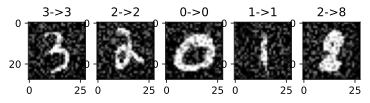

In [17]:
defence_ax=list()
for i in range(len(defence_image_record)):
    defence_ax.append(0)
    defence_ax[i]=plt.subplot(1,5,i+1)
    plt.title("{}->{}".format(defence_image_record[i]['target'],defence_image_record[i]['result']))
    plt.imshow(defence_image_record[i]['data'],cmap='gray')

### A happy try :-)

#### Before everything
The defence method above is using adversarial samples to train the model, while the defence method below is fixing the image by `PGD`!

If `PGD` is making the data update in the oppsite direction, then we can use `PGD` to make the data update in the correct direction to offset the attack to reach the defense purpose.

And this method can be used in information asymmetry situation.

#### Define the network structure

In [18]:
class Try_CNN(CNN):
    def __init__(self):
        super(Try_CNN,self).__init__()

Some tips:
1. Just the same as the network structure defined above. :-)

#### Prepare the data

In [19]:
try_k=3
try_epsilon=0.25
try_reverse_k=5
try_reverse_epsilon=0.15
try_learning_rate=0.005
try_epochs=3
try_model=Try_CNN()
try_criterion=F.nll_loss
try_optimizer=optim.Adam(try_model.parameters(),lr=try_learning_rate)
try_iter_optimizer=optim.Adam(try_model.parameters(),lr=0.05*try_learning_rate)
try_scheduler=StepLR(try_optimizer,step_size=1,gamma=0.8)
try_iter_scheduler=StepLR(try_iter_optimizer,step_size=1,gamma=0.8)

Some tips:
1. `try_k` and `try_epsilon` are used to get the attacked image.
2. `try_reverse_k`and`try_reverse_epsilon` are used to fix the image by `PGD`.

#### Define the training and testing method

In [20]:
def try_train(model,train_data,epoch):
    model.train()
    correct=0
    for batch,(data,target) in enumerate(train_data):
        try_optimizer.zero_grad()
        result=model(data)
        try_train_loss=criterion(result,target)
        try_train_loss.backward()
        pred=result.argmax(dim=1,keepdim=True)
        accuracy=pred.eq(target.view_as(pred)).sum().item()
        correct+=accuracy
        try_loss_record.append(try_train_loss.item())
        try_accuracy_record.append(accuracy/len(data))
        try_optimizer.step()
        if batch%10==0 :
            print("Try Epoch{}:[{}/{}({:.0f}%)]\tLoss:{:.6f}\tAccuracy:{}/{}({:.2f}%)".format(
                epoch+1,batch*len(data),len(train_data.dataset),
                100.*batch*len(data)/len(train_data.dataset),try_train_loss.item(),
                correct,10*len(data),100.*correct/(10*len(data))))
            correct=0
def try_test(model,test_data,k,epsilon,reverse_k,reverse_epsilon):
    model.eval()
    loss=0
    correct=0
    for batch,(data,target) in enumerate(test_data):
        data.requires_grad=True
        for i in range(k-1):
            data.retain_grad()
            data_temp=data+torch.Tensor(np.random.uniform(-epsilon,epsilon,data.shape))
            model.zero_grad()
            result=model(data_temp)
            defence_test_loss=try_criterion(result,target)
            defence_test_loss.backward(retain_graph=True)
            data_grad=data.grad.data
            data=FGSM(data_temp,epsilon,data_grad)
        ##################################################################
        for i in range(reverse_k-1):
            data.retain_grad()
            try_iter_optimizer.zero_grad()
            model.zero_grad()
            data_temp=data+torch.Tensor(np.random.uniform(-reverse_epsilon,reverse_epsilon,data.shape))
            result=model(data_temp)
            try_train_loss=try_criterion(result,target)
            try_train_loss.backward(retain_graph=True)
            data_grad=data.grad.data
            data=FGSM(data_temp,reverse_epsilon,-1*data_grad)
            try_iter_optimizer.step()
        ##################################################################
        with torch.no_grad():
            result=model(data)
            try_test_loss=defence_criterion(result,target)
            pred=result.argmax(dim=1,keepdim=True)
            accuracy=pred.eq(target.view_as(pred)).sum().item()
            if(len(try_image_record)<5):
                temp={
                    'data':data.detach().reshape(28,28),
                    'target':int(target),
                    'result':int(pred)
                }
                try_image_record.append(temp)
            correct+=accuracy
            loss+=defence_test_loss.item()
        loss/=len(test_data.dataset)
    print("Test Set: Average Loss:{:.6f} Accuracy:{}/{}({:.2f}%)".format(
        loss,correct,
        len(test_data.dataset),
        100.*correct/len(test_data.dataset)))

Some tips:
1. The codes above the first line are getting the attacked images.
2. The codes between the two lines are fixing the images.
3. The codes below the second line are predicting the result.

#### Train and test the model

In [21]:
try_loss_record=list()
try_accuracy_record=list()
try_image_record=list()
for epoch in range(try_epochs):
    try_train(try_model,train_data,epoch)
    try_test(defence_model,test_data,try_k,try_epsilon,try_reverse_k,try_reverse_epsilon)
    try_iter_scheduler.step()
    try_scheduler.step()

Try Epoch1:[0/60000(0%)]	Loss:2.310563	Accuracy:9/600(1.50%)
Try Epoch1:[600/60000(1%)]	Loss:1.259311	Accuracy:166/600(27.67%)
Try Epoch1:[1200/60000(2%)]	Loss:0.732722	Accuracy:383/600(63.83%)
Try Epoch1:[1800/60000(3%)]	Loss:1.009320	Accuracy:478/600(79.67%)
Try Epoch1:[2400/60000(4%)]	Loss:0.347420	Accuracy:513/600(85.50%)
Try Epoch1:[3000/60000(5%)]	Loss:0.327796	Accuracy:536/600(89.33%)
Try Epoch1:[3600/60000(6%)]	Loss:0.331209	Accuracy:551/600(91.83%)
Try Epoch1:[4200/60000(7%)]	Loss:0.208347	Accuracy:544/600(90.67%)
Try Epoch1:[4800/60000(8%)]	Loss:0.100411	Accuracy:560/600(93.33%)
Try Epoch1:[5400/60000(9%)]	Loss:0.224798	Accuracy:548/600(91.33%)
Try Epoch1:[6000/60000(10%)]	Loss:0.189828	Accuracy:563/600(93.83%)
Try Epoch1:[6600/60000(11%)]	Loss:0.354189	Accuracy:554/600(92.33%)
Try Epoch1:[7200/60000(12%)]	Loss:0.226193	Accuracy:563/600(93.83%)
Try Epoch1:[7800/60000(13%)]	Loss:0.156443	Accuracy:562/600(93.67%)
Try Epoch1:[8400/60000(14%)]	Loss:0.288372	Accuracy:558/600(93.00

Try Epoch2:[11400/60000(19%)]	Loss:0.071237	Accuracy:587/600(97.83%)
Try Epoch2:[12000/60000(20%)]	Loss:0.012340	Accuracy:589/600(98.17%)
Try Epoch2:[12600/60000(21%)]	Loss:0.086622	Accuracy:586/600(97.67%)
Try Epoch2:[13200/60000(22%)]	Loss:0.039714	Accuracy:591/600(98.50%)
Try Epoch2:[13800/60000(23%)]	Loss:0.061795	Accuracy:580/600(96.67%)
Try Epoch2:[14400/60000(24%)]	Loss:0.008328	Accuracy:588/600(98.00%)
Try Epoch2:[15000/60000(25%)]	Loss:0.038692	Accuracy:590/600(98.33%)
Try Epoch2:[15600/60000(26%)]	Loss:0.191567	Accuracy:593/600(98.83%)
Try Epoch2:[16200/60000(27%)]	Loss:0.041271	Accuracy:584/600(97.33%)
Try Epoch2:[16800/60000(28%)]	Loss:0.058784	Accuracy:592/600(98.67%)
Try Epoch2:[17400/60000(29%)]	Loss:0.056074	Accuracy:581/600(96.83%)
Try Epoch2:[18000/60000(30%)]	Loss:0.076796	Accuracy:591/600(98.50%)
Try Epoch2:[18600/60000(31%)]	Loss:0.053684	Accuracy:588/600(98.00%)
Try Epoch2:[19200/60000(32%)]	Loss:0.196580	Accuracy:584/600(97.33%)
Try Epoch2:[19800/60000(33%)]	Loss

Try Epoch3:[22800/60000(38%)]	Loss:0.150144	Accuracy:590/600(98.33%)
Try Epoch3:[23400/60000(39%)]	Loss:0.004121	Accuracy:594/600(99.00%)
Try Epoch3:[24000/60000(40%)]	Loss:0.030140	Accuracy:595/600(99.17%)
Try Epoch3:[24600/60000(41%)]	Loss:0.007858	Accuracy:594/600(99.00%)
Try Epoch3:[25200/60000(42%)]	Loss:0.080128	Accuracy:592/600(98.67%)
Try Epoch3:[25800/60000(43%)]	Loss:0.025206	Accuracy:587/600(97.83%)
Try Epoch3:[26400/60000(44%)]	Loss:0.013064	Accuracy:588/600(98.00%)
Try Epoch3:[27000/60000(45%)]	Loss:0.007559	Accuracy:587/600(97.83%)
Try Epoch3:[27600/60000(46%)]	Loss:0.005021	Accuracy:591/600(98.50%)
Try Epoch3:[28200/60000(47%)]	Loss:0.156593	Accuracy:587/600(97.83%)
Try Epoch3:[28800/60000(48%)]	Loss:0.043741	Accuracy:587/600(97.83%)
Try Epoch3:[29400/60000(49%)]	Loss:0.096986	Accuracy:588/600(98.00%)
Try Epoch3:[30000/60000(50%)]	Loss:0.014824	Accuracy:597/600(99.50%)
Try Epoch3:[30600/60000(51%)]	Loss:0.012430	Accuracy:593/600(98.83%)
Try Epoch3:[31200/60000(52%)]	Loss

Some tips:
1. We use original training dataset to train the model, and use attacked testing dataset to let the model fix and predict.
2. The accuracy is $99.76\%$, which is much higher than the first method.

#### Show the accuracy and loss curve

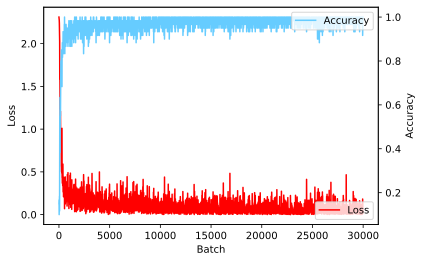

In [22]:
try_x_draw=10*np.arange(len(try_loss_record))
fig = plt.figure()
ax5 = fig.add_subplot()
ax5.plot(try_x_draw, try_loss_record, label = "Loss", color = "#ff0000")
ax5.legend(loc = 4)
ax5.set_ylabel("Loss")
ax5.set_xlabel("Batch")
try_ax = plt.gca()
ax6 = plt.twinx()
ax6.set_ylabel("Accuracy")
ax6.plot(try_x_draw, try_accuracy_record, label = "Accuracy",color="#66ccff")
ax6.legend(loc = 1)
plt.show()

#### Show some fixed examples

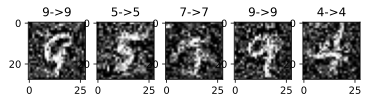

In [23]:
try_ax=list()
for i in range(len(try_image_record)):
    try_ax.append(0)
    try_ax[i]=plt.subplot(1,5,i+1)
    plt.title("{}->{}".format(try_image_record[i]['target'],try_image_record[i]['result']))
    plt.imshow(try_image_record[i]['data'],cmap='gray')

Some tips:
1. Even the fixed image is hard for us to classify, but the model can easily classify.
2. These images reveal that the algorithm could be potentially useful to restore historical relics.

## References

1. [Pytorch Chinese docs](https://pytorch-cn.readthedocs.io/zh/latest/package_references/torch/#math-operations)
2. [Pytorch Documentation](https://pytorch.org/docs/stable/index.html)
3. [Optimizer](https://www.cnblogs.com/tangweijqxx/p/10617752.html)
4. [AlexNet](https://zhuanlan.zhihu.com/p/180554948)
5. Pydroid Samples
6. [FGSM Pytorch](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html?highlight=fgsm)
7. [FGSM Sample](https://zhuanlan.zhihu.com/p/363458808)
8. [I-FGSM](https://blog.csdn.net/u014380165/article/details/90724000)
9. [FGSM Outline](https://arxiv.org/abs/1607.02533)
10. [FGSM Paper](https://arxiv.org/pdf/1607.02533v4.pdf)
11. [PGD Explanation](https://www.cnblogs.com/tangweijqxx/p/10617752.html)
12. [PGD Outline](https://arxiv.org/abs/1706.06083v4)
13. [PGD Paper](https://arxiv.org/pdf/1706.06083.pdf)